In [66]:
!pip install openpyxl

In this notebook I will load the data from the Slimme Check algorithm and perofrm bias tests using AIF360.

Eigenlijk kan ik alleen zelf metrics toepassen op de CMs. want ik heb aleen maar confusion matrices, en geaggregeerde data, voor AIF360 heb ik individuele data nodig. Dat kan ik dus alleen maar doen met Rotterdam en COMPAS.

Eventueel kan ik wel iets met het model en de dummy data. maar niet met de CMs. maar daar kan ik wel zelf veel mee!

In [67]:
# Load the CMs
import pandas as pd

cms_df = pd.read_excel('20240308_CMs_LHR_SlimmeCheck.xlsx')
print(cms_df.describe())
cms_df.head()




             Value
count   480.000000
mean    159.912500
std     204.425098
min       0.000000
25%      32.000000
50%      83.000000
75%     202.250000
max    1024.000000


,Dataset,Model,Feature,Feature_Value,Metric,Value
0,Pilot,BR,geslacht,M,TN,28
1,Pilot,BR,geslacht,M,FP,41
2,Pilot,BR,geslacht,M,FN,25
3,Pilot,BR,geslacht,M,TP,50
4,Pilot,BR,geslacht,V,TN,21


De dataset bevat confusion matrices, dus TN, FP, FN en TP, voor:
- de pilot, prepilot, trainingtrain, trainingtest
- het model before reweighing en after reweiging
- groepen op basis van features
    - m/v
    - leeftijd <30, >30, etc.
    - NL, niet NL
    - etc.

Er zijn 480 rijen, dus 120 CMs in totaal. 

In [68]:
# Overzicht van unieke features 

print("Datasets:")
datasets = cms_df['Dataset'].unique()
print(datasets)
print(f"Aantal: {len(datasets)}")

print("Modellen:")
modellen = cms_df['Model'].unique()
print(modellen)
print(f"Aantal: {len(modellen)}")

print("Features:")
features = cms_df['Feature'].unique()
print(features)
print(f"Aantal: {len(features)}")

Datasets:
['Pilot' 'Prepilot' 'TrainingTrain' 'TrainingTest']
Aantal: 4
Modellen:
['BR' 'AR']
Aantal: 2
Features:
['geslacht' 'Leeftijd<30' 'Leeftijd<40' 'Leeftijd<50' 'IsNederlands'
 'IsWesters' 'IsFulltimeParent' 'IsParttimeParent']
Aantal: 8


In het originele Lighthouse reports onderzoek worden test en trainingsdata weer samengevoegd, omdat de split niet herbruikt wordt. Dit snap ik niet helemaal, dus nog even uitzoeken of ik dat ook ga doen. Voor nu doe ik het wel alvast. 

In [69]:
# Voeg test en train data samen

# Splits
cms_train = cms_df[cms_df['Dataset'] == 'TrainingTrain'].copy()
# drop dataset name
cms_train = cms_train.rename(columns={'Value': 'Value_Train'}).drop('Dataset', axis=1)

cms_test = cms_df[cms_df['Dataset'] == 'TrainingTest'].copy()
cms_test = cms_test.rename(columns={'Value': 'Value_Test'}).drop('Dataset', axis=1)

# Voeg training en test data samen
cms_train_test = cms_train.merge(
    cms_test,
    on=['Model', 'Feature', 'Feature_Value', 'Metric'],
    how='left'
)
# tel values bij elkaar op
cms_train_test['Value'] = cms_train_test['Value_Train'] + cms_train_test['Value_Test']
cms_train_test['Dataset'] = 'TrainTest'
cms_train_test = cms_train_test.drop(['Value_Train', 'Value_Test'], axis=1)

# verwijder oude test/train rijen uit de originele dataset
cms_filtered = cms_df[~cms_df['Dataset'].isin(['TrainingTrain', 'TrainingTest'])]
# voeg de gecombineerde rijen toe
cms_combined = pd.concat([cms_filtered, cms_train_test], ignore_index=True)

# print tail
cms_combined.tail()


,Dataset,Model,Feature,Feature_Value,Metric,Value
347,TrainTest,AR,IsWesters,1,TP,571
348,TrainTest,AR,IsWesters,0,TN,146
349,TrainTest,AR,IsWesters,0,FP,27
350,TrainTest,AR,IsWesters,0,FN,113
351,TrainTest,AR,IsWesters,0,TP,55


Nu berekenen we percentages. Dus per groep de percentages TP, TN, etc.

In [70]:
# voeg nieuwe kolom toe, group_total, alle waarden bij elkaar opgeteld
cms_combined['Group_Size'] = cms_combined.groupby(
    ['Feature', 'Feature_Value', 'Dataset', 'Model']
)['Value'].transform('sum')

# voeg kolom share toe
cms_combined['Share'] = (cms_combined['Value'] / cms_combined['Group_Size']) * 100

cms_combined.head()

,Dataset,Model,Feature,Feature_Value,Metric,Value,Group_Size,Share
0,Pilot,BR,geslacht,M,TN,28,144,19.444444
1,Pilot,BR,geslacht,M,FP,41,144,28.472222
2,Pilot,BR,geslacht,M,FN,25,144,17.361111
3,Pilot,BR,geslacht,M,TP,50,144,34.722222
4,Pilot,BR,geslacht,V,TN,21,128,16.406250


Nu pivotten we de tabel naar wide format, zodat elke rij nu een CM is. We hoeven niet meer naar 4 rijen te kijken, maar elke rij beschrijft een CM voor 1 groep.

In [71]:
# pivot de tabel naar wide
cms_wide = cms_combined.pivot_table(
    index=['Dataset', 'Model', 'Feature', 'Feature_Value', 'Group_Size'],
    columns='Metric',
    values='Share',
    aggfunc='first'
).reset_index()

cms_wide.head()

Metric,Dataset,Model,Feature,Feature_Value,Group_Size,FN,FP,TN,TP
0,Pilot,AR,IsNederlands,0,59,20.338983,27.118644,18.644068,33.898305
1,Pilot,AR,IsNederlands,1,212,16.037736,39.150943,14.622642,30.188679
2,Pilot,AR,IsWesters,1,246,15.853659,37.804878,14.227642,32.113821
3,Pilot,AR,Leeftijd<30,0,236,18.220339,34.745763,17.372881,29.661017
4,Pilot,AR,Leeftijd<30,1,32,0.000000,53.125000,0.000000,46.875000


Nu berekenen we de fairness metrics die Lighthouse Reports heeft berekend. Dit gaan we hierna reproduceren en kijken wat we nog meer kunnen berekenen met AIF360

Nog checken of berekening van iedere metrics idd klopt.

In [72]:
# Totaal, dus 100
cms_wide['TOTAL'] = cms_wide['TN'] + cms_wide['FP'] + cms_wide['TP'] + cms_wide['FN']

#actual negatives
cms_wide['ACT_N'] = cms_wide['FP'] + cms_wide['TN']
#actual positives
cms_wide['ACT_P'] = cms_wide['FN'] + cms_wide['TP']
#predicted positives
cms_wide['PRED_P'] = cms_wide['FP'] + cms_wide['TP']
#predicted negatives
cms_wide['PRED_N'] = cms_wide['FN'] + cms_wide['TN']

#false positive rate, fp tegenover actual negatives. hoeveel van 
# de negatives zijn over het hoofd gezien?
# of, hoeveel zijn onterecht positive bevonden van de negatives?
cms_wide['FPR'] = (cms_wide['FP'] / cms_wide['ACT_N']) * 100  
#positive predicted values, hoeveel van de predicted positives 
# waren ook echt positive?
cms_wide['PPV'] = (cms_wide['TP'] / cms_wide['PRED_P']) * 100
#false discovery rate, hoeveel van de voorspelde positives zijn fout?
cms_wide['FDR'] = (cms_wide['FP'] / cms_wide['PRED_P']) * 100
# true psotive rate: hoeveel van de actual positives zijn voorspeld? 
# dit is meer een performance metric lijkt me
cms_wide['TPR'] = (cms_wide['TP'] / cms_wide['ACT_P']) * 100
# statistical parity, predicted positives moet dan gelijk zijn per groep. 
# dus dit berekenen we met pred_p maar dit is nog niet partiy
cms_wide['STAT_PAR'] = cms_wide['PRED_P']
#error, alle fouten per groep
cms_wide['ERROR'] = cms_wide['FP'] + cms_wide['FN']

cms_wide.head()

Metric,Dataset,Model,Feature,Feature_Value,Group_Size,FN,FP,TN,TP,TOTAL,ACT_N,ACT_P,PRED_P,PRED_N,FPR,PPV,FDR,TPR,STAT_PAR,ERROR
0,Pilot,AR,IsNederlands,0,59,20.338983,27.118644,18.644068,33.898305,100.0,45.762712,54.237288,61.016949,38.983051,59.259259,55.555556,44.444444,62.500000,61.016949,47.457627
1,Pilot,AR,IsNederlands,1,212,16.037736,39.150943,14.622642,30.188679,100.0,53.773585,46.226415,69.339623,30.660377,72.807018,43.537415,56.462585,65.306122,69.339623,55.188679
2,Pilot,AR,IsWesters,1,246,15.853659,37.804878,14.227642,32.113821,100.0,52.032520,47.967480,69.918699,30.081301,72.656250,45.930233,54.069767,66.949153,69.918699,53.658537
3,Pilot,AR,Leeftijd<30,0,236,18.220339,34.745763,17.372881,29.661017,100.0,52.118644,47.881356,64.406780,35.593220,66.666667,46.052632,53.947368,61.946903,64.406780,52.966102
4,Pilot,AR,Leeftijd<30,1,32,0.000000,53.125000,0.000000,46.875000,100.0,53.125000,46.875000,100.000000,0.000000,100.000000,46.875000,53.125000,100.000000,100.000000,53.125000


Nu definieren we wat de privileged groups zijn. Dat is interessant, wie heeft dat bepaald? Daar is analyse van de context bij nodig. Maar die wordt niet gegegeven. 

In [78]:
import numpy as np

# Bepaal privileged groups
def is_privileged(row):
    feature = row['Feature']
    value = row['Feature_Value']
    
    if value == 'M':  # Mannen = privileged
        return 1
    elif value == 'V':  # Vrouwen = unprivileged
        return 0
    elif feature == 'IsNederlands' and value == '1':  # Nederlands = privileged
        return 1
    elif feature == 'IsNederlands' and value == '0':  # Niet-Nederlands = unprivileged
        return 0
    elif feature == 'IsWesters' and value == '1':  # Western = privileged
        return 1
    elif feature == 'IsWesters' and value == '0':  # Not Western = unprivileged
        return 0
    # elke leeftijdsgroep wordt dus vergeleken met jonger en ouder dan die grensleeftijd
    elif feature.startswith('Leeftijd') and value == '1':  # Jonger = privileged
        return 1
    elif feature.startswith('Leeftijd') and value == '0':  # Ouder = unprivileged
        return 0
    elif 'Parent' in feature and value == '1':  # Parent = unprivileged
        return 0
    elif 'Parent' in feature and value == '0':  # No parent = privileged
        return 1
    else:
        return np.nan

# pas toe op de dataset    
cms_wide['is_privileged_group'] = cms_wide.apply(is_privileged, axis=1)
cms_wide.head()

Metric,Dataset,Model,Feature,Feature_Value,Group_Size,FN,FP,TN,TP,TOTAL,...,ACT_P,PRED_P,PRED_N,FPR,PPV,FDR,TPR,STAT_PAR,ERROR,is_privileged_group
0,Pilot,AR,IsNederlands,0,59,20.338983,27.118644,18.644068,33.898305,100.0,...,54.237288,61.016949,38.983051,59.259259,55.555556,44.444444,62.500000,61.016949,47.457627,0
1,Pilot,AR,IsNederlands,1,212,16.037736,39.150943,14.622642,30.188679,100.0,...,46.226415,69.339623,30.660377,72.807018,43.537415,56.462585,65.306122,69.339623,55.188679,1
2,Pilot,AR,IsWesters,1,246,15.853659,37.804878,14.227642,32.113821,100.0,...,47.967480,69.918699,30.081301,72.656250,45.930233,54.069767,66.949153,69.918699,53.658537,1
3,Pilot,AR,Leeftijd<30,0,236,18.220339,34.745763,17.372881,29.661017,100.0,...,47.881356,64.406780,35.593220,66.666667,46.052632,53.947368,61.946903,64.406780,52.966102,0
4,Pilot,AR,Leeftijd<30,1,32,0.000000,53.125000,0.000000,46.875000,100.0,...,46.875000,100.000000,0.000000,100.000000,46.875000,53.125000,100.000000,100.000000,53.125000,1


Nu wil ik de feature values naar groepnamen vertalen

In [89]:
# Translate to name
def translate(row):
    feature = row['Feature']
    value = row['Feature_Value']
    
    if value == 'M':  # Mannen = privileged
        return 'Mannen'
    elif value == 'V':  # Vrouwen = unprivileged
        return "Vrouwen"
    elif feature == 'IsNederlands' and value == '1':  # Nederlands = privileged
        return "Nederlands"
    elif feature == 'IsNederlands' and value == '0':  # Niet-Nederlands = unprivileged
        return "NietNederlands"
    elif feature == 'IsWesters' and value == '1':  # Western = privileged
        return "Westers"
    elif feature == 'IsWesters' and value == '0':  # Not Western = unprivileged
        return "NietWesters"
    # elke leeftijdsgroep wordt dus vergeleken met jonger en ouder dan die grensleeftijd
    elif feature=='Leeftijd<30' and value == '1':  # Jonger = privileged
        return "Onder30"
    elif feature=='Leeftijd<30' and value == '0':  # Jonger = privileged
        return "Boven30"
    elif feature=='Leeftijd<40' and value == '1':  # Jonger = privileged
        return "Onder40"
    elif feature=='Leeftijd<40' and value == '0':  # Jonger = privileged
        return "Boven40"
    elif feature=='Leeftijd<50' and value == '1':  # Jonger = privileged
        return "Onder50"
    elif feature=='Leeftijd<50' and value == '0':  # Jonger = privileged
        return "Boven50"
    elif 'Parent' in feature and value == '1':  # Parent = unprivileged
        return "Ouder"
    elif 'Parent' in feature and value == '0':  # No parent = privileged
        return "GeenOuder"
    else:
        return np.nan
    
# voeg column met group name toe  
cms_wide['Group_Name'] = cms_wide.apply(translate, axis=1)
cms_wide.head()

Metric,Dataset,Model,Feature,Feature_Value,Group_Size,FN,FP,TN,TP,TOTAL,...,PRED_P,PRED_N,FPR,PPV,FDR,TPR,STAT_PAR,ERROR,is_privileged_group,Group_Name
0,Pilot,AR,IsNederlands,0,59,20.338983,27.118644,18.644068,33.898305,100.0,...,61.016949,38.983051,59.259259,55.555556,44.444444,62.500000,61.016949,47.457627,0,NietNederlands
1,Pilot,AR,IsNederlands,1,212,16.037736,39.150943,14.622642,30.188679,100.0,...,69.339623,30.660377,72.807018,43.537415,56.462585,65.306122,69.339623,55.188679,1,Nederlands
2,Pilot,AR,IsWesters,1,246,15.853659,37.804878,14.227642,32.113821,100.0,...,69.918699,30.081301,72.656250,45.930233,54.069767,66.949153,69.918699,53.658537,1,Westers
3,Pilot,AR,Leeftijd<30,0,236,18.220339,34.745763,17.372881,29.661017,100.0,...,64.406780,35.593220,66.666667,46.052632,53.947368,61.946903,64.406780,52.966102,0,Boven30
4,Pilot,AR,Leeftijd<30,1,32,0.000000,53.125000,0.000000,46.875000,100.0,...,100.000000,0.000000,100.000000,46.875000,53.125000,100.000000,100.000000,53.125000,1,Onder30


In [90]:
# converteer naar long format
# dus nu hebben we per metric voor iedere groep de waarde

metrics_cols = ["TN", "FP", "FN", "TP", "TOTAL", "ACT_N", "ACT_P", 
                "PRED_P", "PRED_N", "FPR", "PPV", "FDR", "STAT_PAR", "TPR", "ERROR"]

cms_long = cms_wide.melt(
    id_vars=[col for col in cms_wide.columns if col not in metrics_cols],
    value_vars=metrics_cols,
    var_name='Metric',
    value_name='Value'
)

cms_long.head()

,Dataset,Model,Feature,Feature_Value,Group_Size,is_privileged_group,Group_Name,Metric,Value
0,Pilot,AR,IsNederlands,0,59,0,NietNederlands,TN,18.644068
1,Pilot,AR,IsNederlands,1,212,1,Nederlands,TN,14.622642
2,Pilot,AR,IsWesters,1,246,1,Westers,TN,14.227642
3,Pilot,AR,Leeftijd<30,0,236,0,Boven30,TN,17.372881
4,Pilot,AR,Leeftijd<30,1,32,1,Onder30,TN,0.000000


Nu berekenen we de verschillen in fairness metrics tussen de privileged en non-privileged groups
Mijn FDR diff komt niet overeen met die van lighthouse. Dat komt omdat zij ipv FDR-FDR, FDR - FDP doen. Dus eigenlijk kloppen al hun conclusies over False discovery rate differences niet.

In [ ]:
# Selecteer relevante kolommen
cms_amsti = cms_wide[[
    'Dataset', 'Model', 'Feature', 'is_privileged_group',
    'Feature_Value', 'Group_Size', 'FP', 'FPR', 'FDR', 'PRED_P'
]].copy()

# Label privileged/unprivileged
cms_amsti['is_privileged_group'] = cms_amsti['is_privileged_group'].map({
    1: 'privileged',
    0: 'unprivileged'
})

# Pivot: één rij per feature, kolommen voor privileged vs unprivileged
cms_amsti_wide = cms_amsti.pivot_table(
    index=['Dataset', 'Model', 'Feature'],
    columns='is_privileged_group',
    values=['Feature_Value', 'Group_Size', 'FP', 'FPR', 'FDR', 'PRED_P'],
    aggfunc='first'
).reset_index()

# Flatten column names
cms_amsti_wide.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                           for col in cms_amsti_wide.columns.values]

# Bereken verschillen: hoeveel % hoger is de unprivileged group?
cms_amsti_wide['FP_amsti_diff'] = 100 * (
    (cms_amsti_wide['FP_unprivileged'] - cms_amsti_wide['FP_privileged']) / 
    cms_amsti_wide['FP_privileged']
)

cms_amsti_wide['FPR_amsti_diff'] = 100 * (
    (cms_amsti_wide['FPR_unprivileged'] - cms_amsti_wide['FPR_privileged']) / 
    cms_amsti_wide['FPR_privileged']
)

## foutje ontdekt bijlighthouse! zij doen fdr-fpr om dit te berekenen. klopt dus niet. 
# hoe heeft amsterdam dit zelf gedaan? 
cms_amsti_wide['FDR_amsti_diff'] = 100 * (
    (cms_amsti_wide['FDR_unprivileged'] - cms_amsti_wide['FDR_privileged']) / 
    cms_amsti_wide['FDR_privileged']
)

cms_amsti_wide['PRED_P_amsti_diff'] = 100 * (
    (cms_amsti_wide['PRED_P_unprivileged'] - cms_amsti_wide['PRED_P_privileged']) / 
    cms_amsti_wide['PRED_P_privileged']
)

cms_amsti_wide.head()
#print(cms_amsti_wide.shape)

# hier gaat iets mis. de differences komen niet overeen. FDR diff gaat mis
# gevonden: lighthouse reports maakt foutje.

,Dataset,Model,Feature,FDR_privileged,FDR_unprivileged,FP_privileged,FP_unprivileged,FPR_privileged,FPR_unprivileged,Feature_Value_privileged,Feature_Value_unprivileged,Group_Size_privileged,Group_Size_unprivileged,PRED_P_privileged,PRED_P_unprivileged,FP_amsti_diff,FPR_amsti_diff,FDR_amsti_diff,PRED_P_amsti_diff
0,Pilot,AR,IsNederlands,56.462585,44.444444,39.150943,27.118644,72.807018,59.259259,1,0,212.0,59.0,69.339623,61.016949,-30.733102,-18.607764,-21.285141,-12.002767
1,Pilot,AR,IsWesters,54.069767,NaN,37.804878,NaN,72.656250,NaN,1,NaN,246.0,NaN,69.918699,NaN,NaN,NaN,NaN,NaN
2,Pilot,AR,Leeftijd<30,53.125000,53.947368,53.125000,34.745763,100.000000,66.666667,1,0,32.0,236.0,100.000000,64.406780,-34.596211,-33.333333,1.547988,-35.593220
3,Pilot,AR,Leeftijd<40,51.785714,56.944444,38.157895,34.166667,77.333333,62.121212,1,0,152.0,120.0,73.684211,60.000000,-10.459770,-19.670846,9.961686,-18.571429
4,Pilot,AR,Leeftijd<50,49.664430,71.428571,35.576923,39.062500,70.476190,69.444444,1,0,208.0,64.0,71.634615,54.687500,9.797297,-1.463964,43.822394,-23.657718


De volgende dataset bevat per groep de count voor verschillende important features. Bijvoorbeeld geslacht 0 (man), daarvan hebben 49 eerder levensonderhoud aangevraagd

In [33]:
# Load the important feature counts 
if_df = pd.read_excel('20240308_Important_Features_Counts.xlsx')
# zeroes vervangen door na
if_df['Count'] = if_df['Count'].replace(0, np.nan)
if_df.head()

,Feature,Value,Important Feature,Count,dataset
0,geslacht,0,Dagen sinds einde dienst (+),0,Pilot
1,geslacht,0,Aantal afspraken geen contact (-),0,Pilot
2,geslacht,0,Aantal afspraken no show (+),0,Pilot
3,geslacht,0,Eerder Levensonderhoud aangevraagd (+),49,Pilot
4,geslacht,0,Percentage deelnames gestart (-),0,Pilot


Group labels toevoegen

In [95]:
# feature values naar interpretable labels vertalen
def translate_feature_value(row):
    """Translate binary values to readable labels"""
    feature = row['Feature']
    value = row['Value']
    
    # Gender (NOTE: unsure if 1=F or 1=M!)
    if feature == 'geslacht':
        return 'F' if value == 1 else 'M'  # Assumption: 1=Female
    
    # Age groups
    elif feature == 'Leeftijd<30':
        return 'below 30' if value == 1 else 'above 30'
    elif feature == 'Leeftijd<40':
        return 'below 40' if value == 1 else 'above 40'
    elif feature == 'Leeftijd<50':
        return 'below 50' if value == 1 else 'above 50'
    
    # Nationality
    elif feature == 'IsNederlands':
        return 'Dutch' if value == 1 else 'Not Dutch'
    elif feature == 'IsWesters':
        return 'Western' if value == 1 else 'Not Western'
    
    # Parenthood
    elif feature == 'IsFulltimeParent':
        return 'Full-time parent' if value == 1 else 'Not full-time parent'
    elif feature == 'IsParttimeParent':
        return 'Part-time parent' if value == 1 else 'Not part-time parent'
    
    else:
        return str(value)


if_df['Group_Name'] = if_df.apply(translate_feature_value, axis=1)
if_df.head()


,Feature,Value,Important Feature,Count,dataset,Group_Name
0,geslacht,0,Dagen sinds einde dienst (+),NaN,Pilot,M
1,geslacht,0,Aantal afspraken geen contact (-),NaN,Pilot,M
2,geslacht,0,Aantal afspraken no show (+),NaN,Pilot,M
3,geslacht,0,Eerder Levensonderhoud aangevraagd (+),49.0,Pilot,M
4,geslacht,0,Percentage deelnames gestart (-),NaN,Pilot,M


In [96]:
# Group by feature, feature value, and dataset
# Calculate what % of feature importance counts belong to each group
if_df['total_per_group'] = if_df.groupby(
    ['Group_Name', 'dataset']
)['Count'].transform(lambda x: x.sum(skipna=True))

if_df['share'] = (if_df['Count'] / if_df['total_per_group']) * 100

if_df.head()


,Feature,Value,Important Feature,Count,dataset,Group_Name,total_per_group,share
0,geslacht,0,Dagen sinds einde dienst (+),NaN,Pilot,M,352.0,NaN
1,geslacht,0,Aantal afspraken geen contact (-),NaN,Pilot,M,352.0,NaN
2,geslacht,0,Aantal afspraken no show (+),NaN,Pilot,M,352.0,NaN
3,geslacht,0,Eerder Levensonderhoud aangevraagd (+),49.0,Pilot,M,352.0,13.920455
4,geslacht,0,Percentage deelnames gestart (-),NaN,Pilot,M,352.0,NaN


Ik snap niet helemaal hoe deze important features later nog gebruikt worden. Ze geven nog inzicht in de variabelen maar berekenen we ook nog iets ermeen?

In [99]:
# In R code filteren ze op relvante features, ik laat ze er nu allemaal in
if_df = if_df.copy()

# Verwijder NaN shares
if_df = if_df[
    if_df['share'].notna()
]

# Rank features binnen elke groep (feature + value + dataset)
if_df['rank'] = if_df.groupby(
    ['Feature', 'Value', 'dataset']
)['share'].rank(method='dense', ascending=False)

if_df.head()

,Feature,Value,Important Feature,Count,dataset,Group_Name,total_per_group,share,rank
3,geslacht,0,Eerder Levensonderhoud aangevraagd (+),49.0,Pilot,M,352.0,13.920455,4.0
7,geslacht,0,Dagen sinds einde dienst (-),11.0,Pilot,M,352.0,3.125000,5.0
8,geslacht,0,Totaal vermogen (+),66.0,Pilot,M,352.0,18.750000,3.0
14,geslacht,0,Dagen sinds verhuizing (+),101.0,Pilot,M,352.0,28.693182,2.0
16,geslacht,0,Percentage deelnames gestart (+),125.0,Pilot,M,352.0,35.511364,1.0


Nu ga ik eerst het onderzoek van Lighthouse reports reproduceren. Zij hadden specifieke RQs, dit ging vooral over het effect van het reweighing van het model. Daarna ga ik mijn aanvullende bias analyses doen. RQ1: how did rewerighing affect various fairness metrics? (ik ben zelf denk ik niet per se op zoek naar deze verschillen. )

Eerste stap is visualisaties maken. We kijken nu per groep, per fairness metric, hoe is deze veranderd na reweighing van het model? We gaan weer terug naar dataset cms_long
FDR, Fp en STAT_PAR voor: 
1. IsNederlands
2. Geslacht
2. IsFulltimeParent

En die dan vergelijken BR en AR. 

Daarna: de group % difference before and after rewighing vergelijken in ene plot. 

In [145]:


cms_amsti_wide.to_csv('cms_amsti_wide.csv', index=False)

cms_amsti_wide.head()

,Dataset,Model,Feature,FDR_privileged,FDR_unprivileged,FP_privileged,FP_unprivileged,FPR_privileged,FPR_unprivileged,Feature_Value_privileged,Feature_Value_unprivileged,Group_Size_privileged,Group_Size_unprivileged,PRED_P_privileged,PRED_P_unprivileged,FP_amsti_diff,FPR_amsti_diff,FDR_amsti_diff,PRED_P_amsti_diff
0,Pilot,AR,IsNederlands,56.462585,44.444444,39.150943,27.118644,72.807018,59.259259,1,0,212.0,59.0,69.339623,61.016949,-30.733102,-18.607764,-21.285141,-12.002767
1,Pilot,AR,IsWesters,54.069767,NaN,37.804878,NaN,72.656250,NaN,1,NaN,246.0,NaN,69.918699,NaN,NaN,NaN,NaN,NaN
2,Pilot,AR,Leeftijd<30,53.125000,53.947368,53.125000,34.745763,100.000000,66.666667,1,0,32.0,236.0,100.000000,64.406780,-34.596211,-33.333333,1.547988,-35.593220
3,Pilot,AR,Leeftijd<40,51.785714,56.944444,38.157895,34.166667,77.333333,62.121212,1,0,152.0,120.0,73.684211,60.000000,-10.459770,-19.670846,9.961686,-18.571429
4,Pilot,AR,Leeftijd<50,49.664430,71.428571,35.576923,39.062500,70.476190,69.444444,1,0,208.0,64.0,71.634615,54.687500,9.797297,-1.463964,43.822394,-23.657718


Onderstaande metrics en features kunnen dus aangepast worden om meer mee te nemen in de plots

In [119]:
# Subset to relevant definitions, datasets, and characteristics. Deze filteren ze in het lighthouse onderzoek
# dus we kijken alleen naar prepilot!
cms_city_perspective = cms_long[
    (cms_long['Dataset'].isin(['Prepilot'])) &
    (cms_long['Metric'].isin(['STAT_PAR', 'FDR', 'FP'])) &
    (cms_long['Feature'].isin(['geslacht', 'IsNederlands', 
                                   'IsFulltimeParent']))
].copy()

# voor volgorde br en ar
cms_city_perspective['Model'] = pd.Categorical(
    cms_city_perspective['Model'],
    categories=['BR', 'AR'],
    ordered=True
)


cms_city_perspective.head()

,Dataset,Model,Feature,Feature_Value,Group_Size,is_privileged_group,Group_Name,Metric,Value
106,Prepilot,AR,IsFulltimeParent,0,1070,1,GeenOuder,FP,10.467290
107,Prepilot,AR,IsFulltimeParent,1,185,0,Ouder,FP,12.432432
108,Prepilot,AR,IsNederlands,0,345,0,NietNederlands,FP,8.695652
109,Prepilot,AR,IsNederlands,1,876,1,Nederlands,FP,11.757991
119,Prepilot,AR,geslacht,M,693,1,Mannen,FP,11.832612


Deze plots laten het verschil in fairness metrics zien BR en AR

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Plotstijl
sns.set(style="whitegrid")

output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# lijst van features om te itereren
features = cms_city_perspective['Feature'].unique()

for feature in features:
    subset = cms_city_perspective[cms_city_perspective['Feature'] == feature]
    
    # FacetGrid per Metric (3 rijen)
    g = sns.catplot(
        data=subset,
        kind="bar",
        x="Model",               # Model_AR vs Model_BR
        y="Value",
        hue="Feature_Value",     # Kleur per waarde (man/vrouw etc.)
        row="Metric",            # Één rij per metric
        sharey=False,
        height=4,
        aspect=2
    )
    
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f"{feature}: Vergelijking fairness metrics tussen AR en BR", fontsize=12)
    
    # labels en layout
    for ax in g.axes.flatten():
        ax.set_xlabel("Model")
        ax.set_ylabel("Waarde")
        ax.legend(title="Groep")

    # Opslaan
    plot_path = os.path.join(output_dir, f"P1-{feature}_fairness_comparison.png")
    g.savefig(plot_path, dpi=300)
    plt.close(g.fig)
    
    print(f"Plot opgeslagen: {plot_path}")

  


C:\Users\jetve\AppData\Local\Temp\ipykernel_8144\2097301123.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Groep")


Plot opgeslagen: plots\P1-IsFulltimeParent_fairness_comparison.png


C:\Users\jetve\AppData\Local\Temp\ipykernel_8144\2097301123.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Groep")


Plot opgeslagen: plots\P1-IsNederlands_fairness_comparison.png


C:\Users\jetve\AppData\Local\Temp\ipykernel_8144\2097301123.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Groep")


Plot opgeslagen: plots\P1-geslacht_fairness_comparison.png


Tot hierboven gaat alles goed. Hieronder niet meer. Even opnieuw proberen.
Deze plots laten het verschil zien in verschil tussen de privlieged en non-privileged groups, BR en AR

In [ ]:
# eerst de amsti data weer naar long converteren zodat we daar weer hetzelfde mee kunnen doen

# Selecteer alleen relevante fairness metrics
metrics = ['FDR_amsti_diff', 'FPR_amsti_diff', 'PRED_P_amsti_diff']

# Zet data in lang formaat (zodat je makkelijk met seaborn kunt facet’en)
cms_amsti_long = cms_amsti_wide.melt(
    id_vars=['Dataset', 'Model', 'Feature'],
    value_vars=metrics,
    var_name='Metric',
    value_name='Diff'
)

# Maak de namen wat leesbaarder
cms_amsti_long['Metric'] = cms_amsti_long['Metric'].replace({
    'FDR_amsti_diff': 'False Discovery Rate',
    'FPR_amsti_diff': 'False Positive Rate',
    'PRED_P_amsti_diff': 'Pred_P'
})

# voor volgorde br en ar
cms_amsti_long['Model'] = pd.Categorical(
    cms_amsti_long['Model'],
    categories=['BR', 'AR'],
    ordered=True
)


cms_amsti_long.head()


,Dataset,Model,Feature,Metric,Diff
0,Pilot,AR,IsNederlands,False Discovery Rate,-21.285141
1,Pilot,AR,IsWesters,False Discovery Rate,NaN
2,Pilot,AR,Leeftijd<30,False Discovery Rate,1.547988
3,Pilot,AR,Leeftijd<40,False Discovery Rate,9.961686
4,Pilot,AR,Leeftijd<50,False Discovery Rate,43.822394


In [159]:
# Filter naar relevante metrics en features (zoals in R code)
cms_city_perspective = cms_amsti_long[
    (cms_amsti_long["Dataset"].isin(['Prepilot']))&
    (cms_amsti_long['Metric'].isin(['Pred_P', 'False Discovery Rate', 'False Positive Rate'])) &
    (cms_amsti_long['Feature'].isin(['IsNederlands', 'geslacht', 'IsFulltimeParent']))
].copy()

# voor volgorde br en ar
cms_city_perspective['Model'] = pd.Categorical(
    cms_city_perspective['Model'],
    categories=['BR', 'AR'],
    ordered=True
)

cms_city_perspective.head()

,Dataset,Model,Feature,Metric,Diff
12,Prepilot,AR,IsFulltimeParent,False Discovery Rate,30.188679
13,Prepilot,AR,IsNederlands,False Discovery Rate,-43.112864
19,Prepilot,AR,geslacht,False Discovery Rate,-19.053085
20,Prepilot,BR,IsFulltimeParent,False Discovery Rate,22.804973
21,Prepilot,BR,IsNederlands,False Discovery Rate,-15.833333


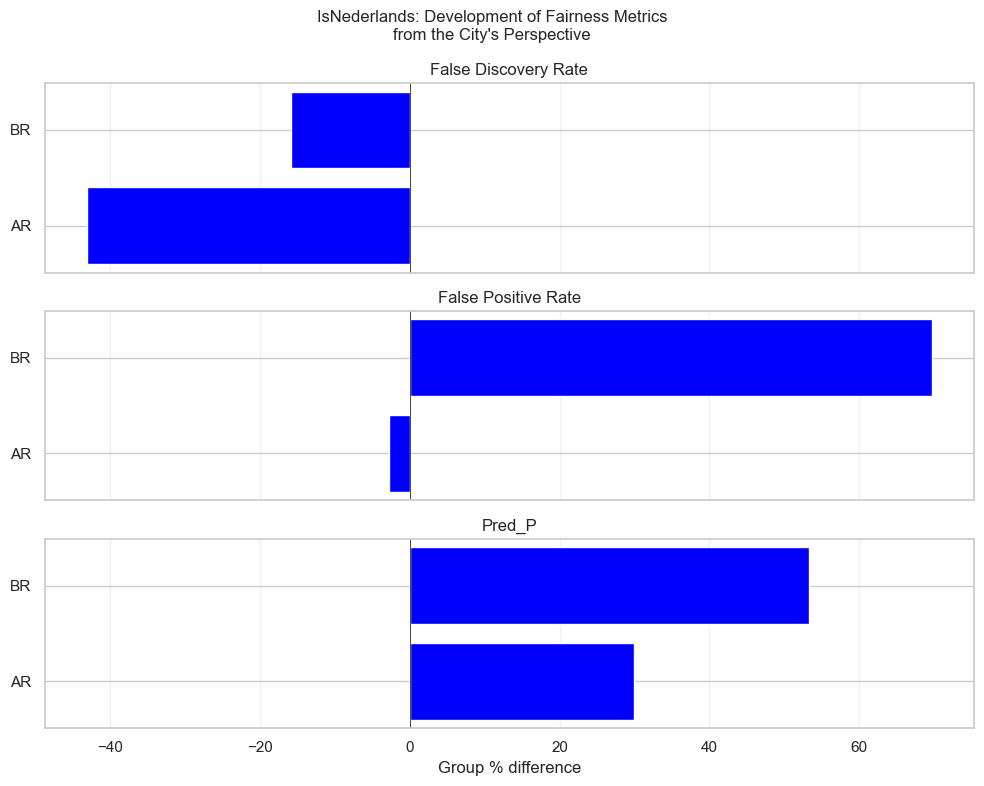

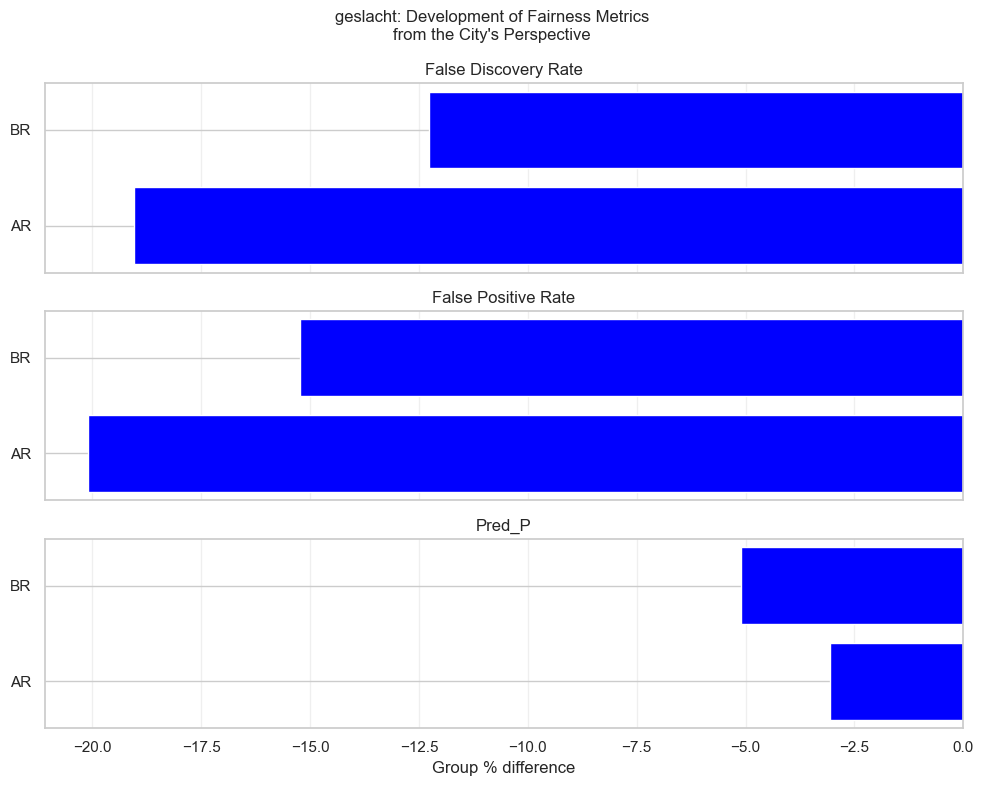

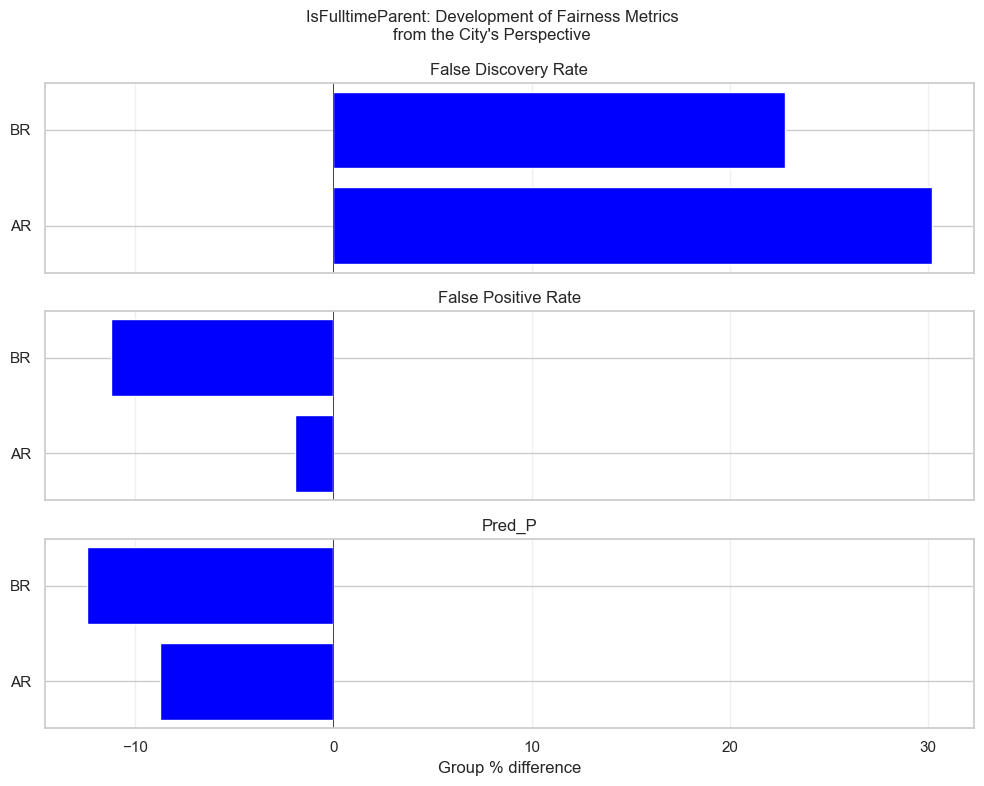

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop over characteristics
for characteristic in ['IsNederlands', 'geslacht', 'IsFulltimeParent']:
    cms_char = cms_city_perspective[cms_city_perspective['Feature'] == characteristic].copy()
    
    
    # Maak de plot
    fig, axes = plt.subplots(len(cms_char['Metric'].unique()), 1, 
                             figsize=(10, 8), sharex=True)
    
    if len(cms_char['Metric'].unique()) == 1:
        axes = [axes]
    
    for idx, metric in enumerate(cms_char['Metric'].unique()):
        #data_subset = cms_char[cms_char['Metric'] == metric].sort_values('order')
        data_subset = cms_char[cms_char['Metric'] == metric]
        
        axes[idx].barh(data_subset['Model'], data_subset['Diff'], color='blue')
        axes[idx].set_ylabel('')
        axes[idx].set_title(metric)
        axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        axes[idx].grid(axis='x', alpha=0.3)
    
    axes[-1].set_xlabel('Group % difference')
    fig.suptitle(f"{characteristic}: Development of Fairness Metrics\nfrom the City's Perspective", 
                 fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'P2-{characteristic}.png', dpi=300, bbox_inches='tight')
    #plt.show()
    
    # Save data
    cms_char.to_csv(f'plots/P2-fairness_definition_comp_{characteristic}.csv', index=False)